# Flower Classification with Transfer Learning (PyTorch)

This notebook explores transfer learning for image classification on the 102-class flower dataset,
including feature extraction vs full fine-tuning, learning rate scheduling, and validation analysis.


In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nunenuh/pytorch-challange-flower-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pytorch-challange-flower-dataset' dataset.
Path to dataset files: /kaggle/input/pytorch-challange-flower-dataset


In [47]:
import os
import matplotlib. pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch. optim as optim
import torchvision
##pip install torchvision
from torchvision import transforms, models, datasets
##https://pytorch. org/docs/stable/ torchrision/indez. html
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

In [48]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'valid': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [49]:
from pathlib import Path
import kagglehub
import os, glob
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# download
path = kagglehub.dataset_download("nunenuh/pytorch-challange-flower-dataset")
root = Path(path) / "dataset"

train_dir = root / "train"
val_dir   = root / "valid"
test_dir  = root / "test"




data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'valid': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 64
image_datasets = {x: datasets.ImageFolder(os.path.join(root, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes





# test (handle both: with-class-subfolders OR flat images)
def has_class_folders(p: Path) -> bool:
    return p.exists() and any(x.is_dir() for x in p.iterdir())

class FlatImageDataset(Dataset):
    def __init__(self, img_dir: Path, transform=None, exts=(".jpg", ".jpeg", ".png", ".webp")):
        self.img_dir = Path(img_dir)
        self.transform = transform
        files = []
        for ext in exts:
            files.extend(self.img_dir.glob(f"*{ext}"))
            files.extend(self.img_dir.glob(f"*{ext.upper()}"))
        self.files = sorted(files)
        if len(self.files) == 0:
            raise FileNotFoundError(f"No images found directly under: {self.img_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fp = self.files[idx]
        img = Image.open(fp).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, fp.name  # return filename for submission

if has_class_folders(test_dir):
    test_ds = datasets.ImageFolder(test_dir, transform=data_transforms)
else:
    test_ds = FlatImageDataset(test_dir, transform=data_transforms)

# loaders
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
# val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)





Using Colab cache for faster access to the 'pytorch-challange-flower-dataset' dataset.


In [50]:
print("train classes:", len(image_datasets))

print("test type:", type(test_ds).__name__, "len:", len(test_ds))

train classes: 2
test type: FlatImageDataset len: 819


In [ ]:
image_datasets

In [7]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7d69e1e5ba40>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7d68ae042ea0>}

In [51]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [52]:


path = kagglehub.dataset_download("nunenuh/pytorch-challange-flower-dataset")
root = Path(path)

with open(root / "cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

print("loaded:", len(cat_to_name))
print(list(cat_to_name.items())[:5])


Using Colab cache for faster access to the 'pytorch-challange-flower-dataset' dataset.
loaded: 102
[('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster')]


In [ ]:
cat_to_name

Present Flower picture


In [11]:
def im_convert(tensor):
    """ 展示数据"""

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

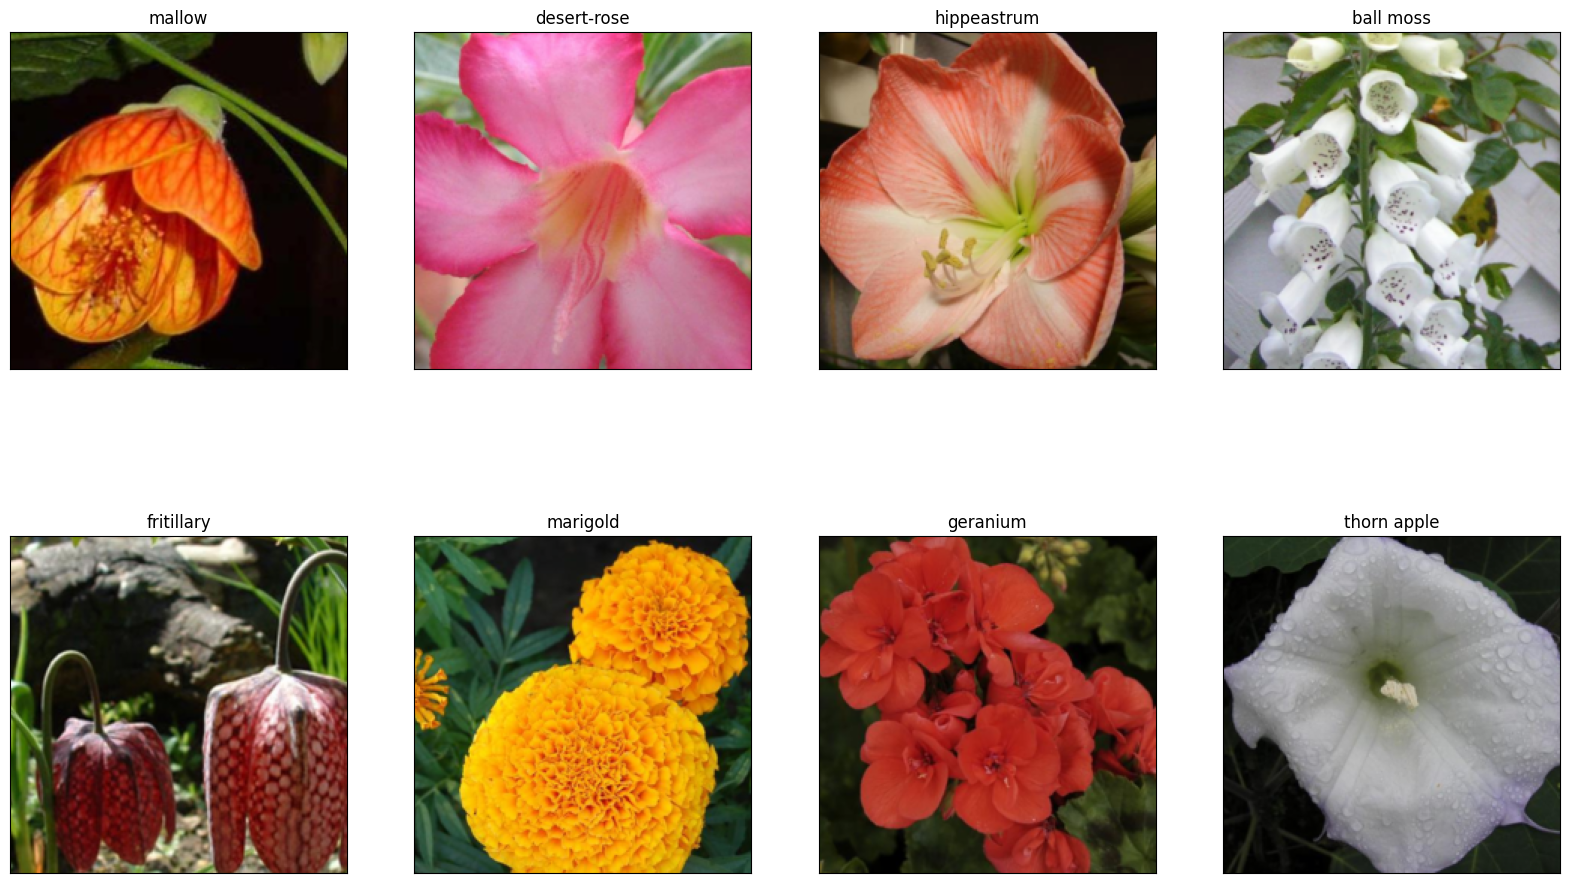

In [12]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2
dataiter = iter(dataloaders['valid'])
inputs, classes = next(dataiter)

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [13]:
##training data

In [55]:
model_name = 'resnet'  # ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']

feature_extract = True

In [56]:
#
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [57]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
model_ft = models.resnet152()
model_ft

In [59]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # change the output
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102),
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [60]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [ ]:
model_ft

In [62]:
# Optimizer
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.NLLLoss()

In [63]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs

training

In [64]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="inception"))

Epoch 0/19
----------
Time elapsed 1m 15s
train Loss: 6.6973 Acc: 0.4029
Time elapsed 1m 21s
valid Loss: 3.0278 Acc: 0.4756
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 2m 37s
train Loss: 1.4984 Acc: 0.6781
Time elapsed 2m 43s
valid Loss: 3.3936 Acc: 0.4939
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 3m 59s
train Loss: 1.4537 Acc: 0.7105
Time elapsed 4m 4s
valid Loss: 2.4389 Acc: 0.6210
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 5m 20s
train Loss: 1.3361 Acc: 0.7505
Time elapsed 5m 26s
valid Loss: 3.2504 Acc: 0.5391
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 6m 41s
train Loss: 1.4234 Acc: 0.7413
Time elapsed 6m 47s
valid Loss: 3.0382 Acc: 0.6137
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 8m 3s
train Loss: 1.4187 Acc: 0.7556
Time elapsed 8m 9s
valid Loss: 3.5259 Acc: 0.5452
Optimizer learning rate : 0.0100000

Epoch 6/19
----------
Time elapsed 9m

Training on all layers

In [69]:
for param in model_ft.parameters():
    param.requires_grad = True

# train on all, decrease lr
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Loss
criterion = nn.NLLLoss()

In [66]:
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer'])

In [70]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------
Time elapsed 1m 25s
train Loss: 0.6790 Acc: 0.8810
Time elapsed 1m 31s
valid Loss: 2.2637 Acc: 0.7543
Optimizer learning rate : 0.0001000

Epoch 1/14
----------
Time elapsed 2m 57s
train Loss: 0.5185 Acc: 0.9077
Time elapsed 3m 3s
valid Loss: 2.0366 Acc: 0.7653
Optimizer learning rate : 0.0001000

Epoch 2/14
----------
Time elapsed 4m 30s
train Loss: 0.4596 Acc: 0.9110
Time elapsed 4m 36s
valid Loss: 1.9835 Acc: 0.7616
Optimizer learning rate : 0.0001000

Epoch 3/14
----------
Time elapsed 6m 1s
train Loss: 0.4590 Acc: 0.9106
Time elapsed 6m 7s
valid Loss: 1.8927 Acc: 0.7677
Optimizer learning rate : 0.0001000

Epoch 4/14
----------
Time elapsed 7m 34s
train Loss: 0.4658 Acc: 0.9106
Time elapsed 7m 40s
valid Loss: 1.9932 Acc: 0.7689
Optimizer learning rate : 0.0001000

Epoch 5/14
----------
Time elapsed 9m 6s
train Loss: 0.4037 Acc: 0.9171
Time elapsed 9m 12s
valid Loss: 1.9720 Acc: 0.7702
Optimizer learning rate : 0.0001000

Epoch 6/14
----------
Time elapsed 10m

In [97]:
ckpt_path = "checkpoint.pth"
checkpoint = torch.load(ckpt_path)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer'])

In [98]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std

    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))

    return img

In [100]:
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter)

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [101]:
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([76, 65, 97, 18, 18, 77, 97, 96, 65, 76, 78, 65, 24, 78, 85, 89, 43,
       83, 53, 43, 38, 52, 80, 83, 76, 64, 49, 87, 95, 82, 78,  3, 77, 49,
       17, 51, 99, 46, 59, 38, 77,  0, 85, 49, 65, 54, 57, 96, 54, 65, 49,
       59, 36, 81, 73, 75, 83, 46, 39, 64, 65, 73, 54, 83])

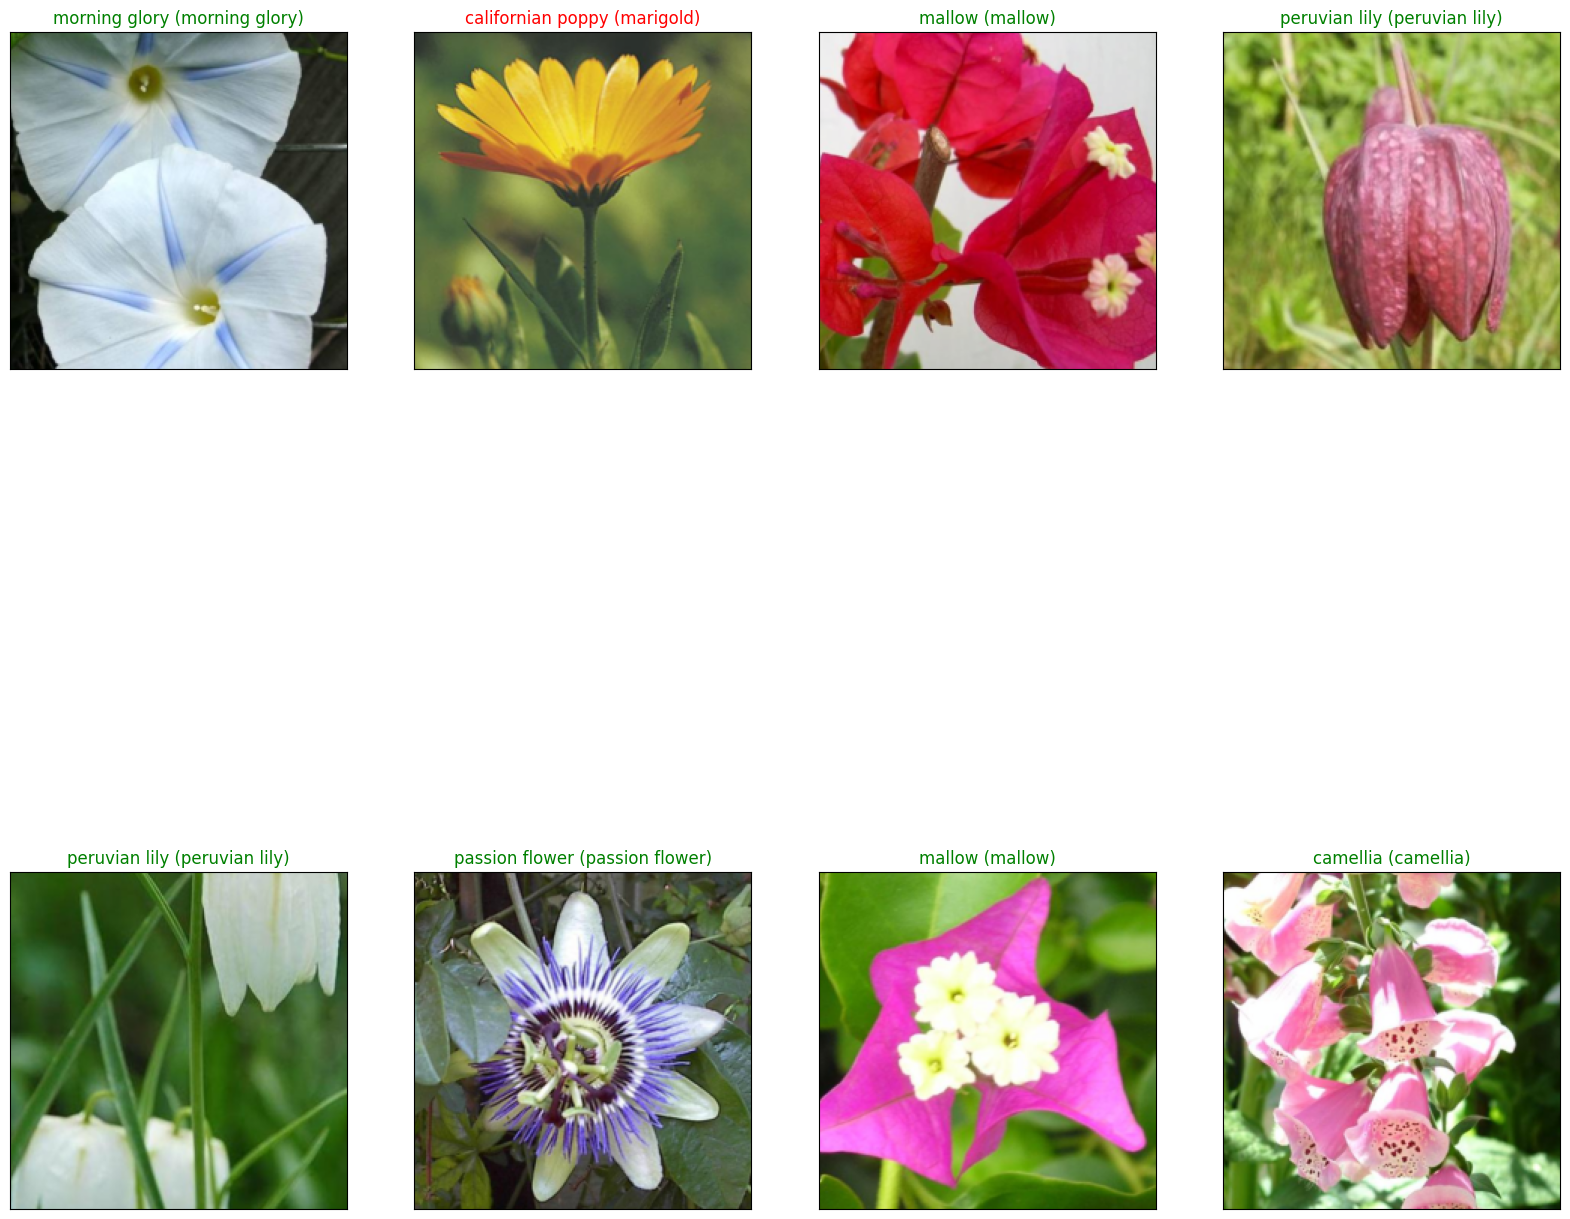

In [103]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()

In [106]:
import torch

def test_with_labels(model, test_loader, device, criterion=None):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    avg_loss = (running_loss / total) if criterion is not None else None
    return acc, avg_loss

# 用你加载的 best checkpoint 的 model
test_acc, test_loss = test_with_labels(model_ft, dataloaders['valid'], device, criterion=criterion)
print("Test Acc:", test_acc)
print("Test Loss:", test_loss)


Test Acc: 0.7811735941320294
Test Loss: 1.8725583920560431


## Next Steps
- Add an end-to-end inference pipeline for user-uploaded images
- Build a lightweight demo (e.g., Streamlit/Gradio)
